# The Efficiency of the Hadley Cell Response to Wide Variations in Ocean Heat Transport

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
from pyCESM.cam_diag import open_dataset
import pyCESM.physconst as const
from xarray.ufuncs import sin,cos,exp,log,deg2rad



pyCESM package can be found at https://github.com/brian-rose/pyCESM

Model output can be found at http://thredds.atmos.albany.edu:8080/thredds/catalog/CESMA/catalog.html

### Loading in data/configuring dictionaries

In [2]:
Nlist=[1,2,3,4,6,8]
amplist = [1,2,3,4]
obllist = [0., 23.45]
Nstr = []
ampstr = []
for N in Nlist:
    Nstr.append('N'+str(N))
for amp in amplist:
    ampstr.append(str(amp)+'PW')

In [3]:
Ndim = xr.DataArray(Nlist,dims='N')
Narray = xr.DataArray(Nstr,dims='N',coords={'N':Ndim})
ampdim = xr.DataArray(amplist,dims='amplitude')
amparray = xr.DataArray(ampstr,dims='amplitude',coords={'amplitude':ampdim})
obldim = xr.DataArray(obllist,dims='obliquity')

In [4]:
#  Accessing the CAM4 model runs remotely from the ramadda data server

#datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/cesm/aquaplanet_som/"
datapath1 = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"        
datapath2=  "/clim/"


model= "QAqu_ctrl"
ctrl = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc", decode_times=False, verbose=False).mean(dim='time')
filename = 'QAqu_CO2.cam.h0.zonclim.nc'
model= "QAqu_CO2"
CO2 = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc", decode_times=False, verbose=False).mean(dim='time')



In [5]:
### Key Functions in analysis

#  symmetric ocean heat transport q-fluxes
def Nconv(N,phi):
    return -((1.+2.*N)**(N+0.5))/((2.*N)**N) * (np.cos(phi)**(2.*N))*(1.-2.*N*(np.tan(phi))**2)

def OHTconvergence(lat, N=2, amp=1.):
    '''lat is latitude in degrees.
    N is meridional scale parameter (positive integer)
    amp is amplitude of peak heat transport in PW'''
    phi = np.deg2rad(lat)
    amp1PW = 3.92  #  in W/m^2, the scaling factor that gives 1 PW peak transport
    return amp*amp1PW*Nconv(N,phi)



def column_integral(field):
    '''Mass-weighted vertical integral of input field.'''
    dp =ctrl.dP
    g=const.gravit

    return (field * dp/g ).sum(dim='lev')

def global_mean(array):
    
    return np.sum(array*ctrl.gw)/np.sum(ctrl.gw)


### Calculated V_adj term
def V_adj(run):
    V=run.V
    N=np.zeros_like(V)
    S=np.zeros_like(N)
    
    for y in range(26):
            for x in range(96):
                if V[y,x] > 0:
                    N[y,x]= V[y,x]
                elif V[y,x] < 0: 
                    S[y,x]= V[y,x]
    S=np.array(S)
    N=np.array(N)
    n= column_integral(N)  
    s=column_integral(S)   
    V_ad=N-(S*np.array(n/s))
    Vad_array = xr.DataArray(V_ad, coords = ctrl.V.coords, dims = ctrl.V.dims)
    return Vad_array

#def V_adj(run):
#    V=run.V
#    v_imbalance=np.mean(run.V,axis=0)
#    return V - v_imbalance
def overturning_improved(run):
    #  Better method: use the actual layer pressure intervals to weight the integral
    field = (run.V_adj * run.dP * cos(deg2rad(run.lat)))
    if 'lon' in field.dims:
        field = field.mean(dim='lon')
    factor = 2*np.pi*const.rearth/const.gravit*1E-9
    psi = np.cumsum( field, axis=field.get_axis_num('lev'))*factor
    return psi


def column_integral(field):
    '''Mass-weighted vertical integral of input field.'''
    dp =ctrl.dP
    g=const.gravit

    return (field * dp/g ).sum(dim='lev')

def HC_flux(run):
    MSE = run.MSE
    V = run.V_adj
    constants=2*np.pi*const.rearth*np.cos(np.deg2rad(ctrl.lat))
    HC_flux=constants*column_integral(MSE*V)
    return HC_flux
    
    

In [6]:
ctrl['V_adj']=V_adj(ctrl)
ctrl['HC_flux']=HC_flux(ctrl)
ctrl['Psi_adj']=overturning_improved(ctrl)
CO2['V_adj']=V_adj(CO2)
CO2['HC_flux']=HC_flux(CO2)
CO2['Psi_adj']=overturning_improved(CO2)

In [7]:
#  Load the whole array of OHT simulations into a single Dataset
allsets = []
prefix = ['QAqu_', 'QAqu23_']
for o, obl in enumerate(obllist):
    thesesets = []
    for n, N in enumerate(Nlist):
        theseruns = []
        for a, amp in enumerate(amplist):

            #filename = prefix[o] + Nstr[n] + '_' + ampstr[a] + '.cam.h0.zonclim.nc'
            model=prefix[o] + Nstr[n] + '_' + ampstr[a]
            thisdataset = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc" , 
                                       decode_times=False, verbose=False).mean(dim='time')
            thisdataset['amplitude'] = amp
            thisdataset['OHTconvergence'] = OHTconvergence(thisdataset.lat, N=N, amp=amp)
            thisdataset['V_adj']=V_adj(thisdataset)
            thisdataset['Psi_adj'] = overturning_improved(thisdataset)
            thisdataset['HC_flux']=HC_flux(thisdataset)
            theseruns.append(thisdataset)
        thisset = xr.concat(theseruns, dim='amplitude')
        thisset['N'] = N
        thesesets.append(thisset)
    theseruns = xr.concat(thesesets, dim='N')
    theseruns['obliquity'] = obl
    allsets.append(theseruns)
runs = xr.concat(allsets, dim='obliquity')

/Users/mcrencurrel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


In [8]:
# Grid information
lat = ctrl.lat
lev = ctrl.lev
sinlat = sin(deg2rad(lat))
coslat = cos(deg2rad(lat))

In [9]:
#  Actually many of our plots are based on anomalies for a 1 PW OHT increase:
anom1PW = runs.sel(amplitude=2) - runs.sel(amplitude=1)
anom2PW = runs.sel(amplitude=3) - runs.sel(amplitude=2)
anom3PW = runs.sel(amplitude=4) - runs.sel(amplitude=3)

In [10]:
#  Set obliquity on key dictionaries
o = 0

runs = runs.sel(obliquity= o)
anom1PW = anom1PW.sel(obliquity = o)

In [11]:
#  Set colormap used for lineplots
n = 6
colors=plt.cm.viridis(np.linspace(0,.95,n))[::-1] 

## Initial OHT/model analysis

$$ \text{OHT}=\Psi \sin(\phi) \cos(\phi)^{2N}=\Psi x(1-x^2)^N$$
$$ F_{THT}(\phi)=2 \pi a^2 \int_{-\frac{\pi}{2}}^{\phi}  \left[\overline{Q}_{TOA}\right] \cos\phi  d\phi$$
$$ F_{AHT}(\phi)=2 \pi a^2 \int_{-\frac{\pi}{2}}^{\phi} \left( \left[\overline{Q}_{TOA}\right]-\left[\overline{Q}_{sfc}\right]\right)$$

Text(0.5,1,'SST increase')

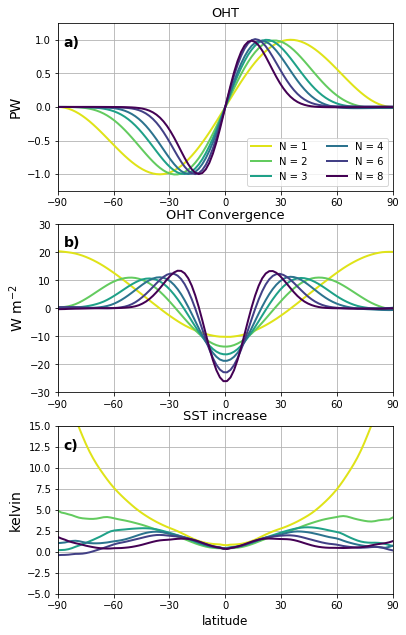

In [12]:
### Figure 1
fig=plt.figure(figsize=(6,10.5))
ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2,sharex = ax1)
ax3=fig.add_subplot(3,1,3,sharex = ax1)
for c,N in enumerate(Nlist):
    ### OHT anomaly
    ax1.plot(lat,anom1PW.HT_ocean.sel(N=N),color=colors[c], linewidth=2, label='N = '+str(N))
    
    ### Qflux anomaly
    ax2.plot(lat,anom1PW.SurfaceHeatFlux.sel(N=N),color=colors[c], linewidth=2, label='N = '+str(N))
    
    ### SST anomaly
    ax3.plot(lat,anom1PW.TS.sel(N=N),color=colors[c], linewidth=2, label='N = '+str(N))
    
### setting ax1 attributes
ax1.grid()
ax1.set_xlim(-90,90)
ax1.set_xticks(range(-90,91,30))
ax1.set_ylim(-1.25,1.25)
ax1.legend(loc='lower right', ncol=2)
ax1.set_ylabel('PW', fontsize=14)
ax1.text(-87,.9,'a)', fontsize=14, fontweight='bold')
ax1.set_title('OHT', fontsize=13)  

### setting ax2 attributes
ax2.grid()
ax2.set_ylim(-30,30)
ax2.set_ylabel('W m$^{-2}$', fontsize=14)
ax2.set_title('OHT Convergence', fontsize=13)
ax2.text(-87,22,'b)', fontsize=14, fontweight='bold')


### setting ax3 attributes
ax3.grid()
ax3.set_ylim(-5,15)
ax3.set_yticks(np.linspace(-5,15,9))
ax3.set_ylabel('kelvin', fontsize=14)
ax3.set_xlabel('latitude', fontsize=12)
ax3.text(-87,12.2,'c)', fontsize=14, fontweight='bold')
ax3.set_title('SST increase', fontsize=13)

Text(0.5,1,'MMC Component')

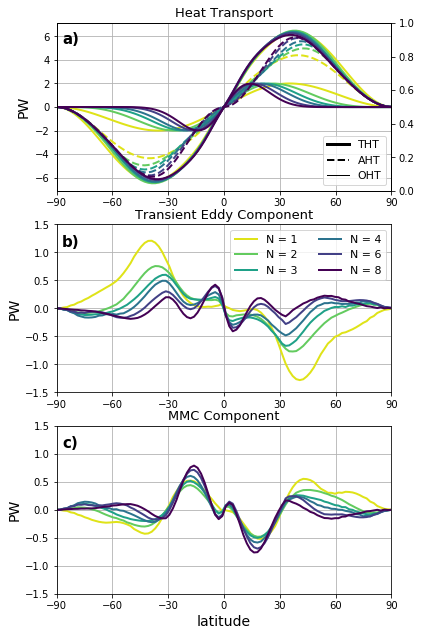

In [13]:
### Figure 2


fig=plt.figure(figsize=(6,10.5))

ax1=fig.add_subplot(3,1,1)
ax2 = ax1.twinx()
ax3=fig.add_subplot(3,1,2,sharex = ax1)
ax4=fig.add_subplot(3,1,3,sharex = ax1)


for c,N in enumerate(Nlist):
    ### Plotting HT breakdown
    ax1.plot(lat,runs.HT_total.sel(N=N, amplitude = 2),color=colors[c], linewidth=2)
    ax1.plot(lat,runs.HT_ocean.sel(N=N, amplitude = 2),color=colors[c], linewidth=2)
    ax1.plot(lat,runs.HT_atm.sel(N=N, amplitude = 2),color=colors[c],linestyle='--', linewidth=2)
    
    ### Plotting transient eddy energy flux component
    TE_anom = (runs.HT_atm.sel(N=N, amplitude = 2)-(runs.HC_flux.sel(N=N, amplitude = 2)/1E15)) - \
    (runs.HT_atm.sel(N=N, amplitude = 1)-(runs.HC_flux.sel(N=N, amplitude = 1)/1E15))
    ax3.plot(lat,TE_anom,color=colors[c],linewidth=2,label='N = '+str(N))
    
    ### Plotting MMC energy flux component
    HC_anom=anom1PW.HC_flux.sel(N=N)/1E15
    ax4.plot(lat,HC_anom,color=colors[c],linewidth=2,label='N = '+str(N))
    
    
    
### setting ax1 attributes   
ax1.grid()
ax1.set_xlim(-90,90)
ax1.set_xticks(range(-90,91,30))
ax1.text(-87,5.4,'a)', fontsize=15, fontweight='bold')
ax1.set_ylabel('PW', fontsize=14)
ax1.set_title('Heat Transport', fontsize=13)

ax2 = ax1.twinx()
ax2.plot([],'k',linewidth=3,label='THT')
ax2.plot([],'k--',linewidth=2,label='AHT')
ax2.plot([],'k',linewidth=1,label='OHT')
ax2.legend(loc='lower right', fontsize = 11)
plt.tick_params(
    axis='y',          
    which='both',      
    right='off',      
    labelright='off')




### Setting ax3 attributes

ax3.grid()
ax3.text(-87,1.1,'b)', fontsize=15, fontweight='bold')
ax3.set_ylabel('PW', fontsize=14)
ax3.set_ylim(-1.5,1.5)
ax3.legend(ncol=2, fontsize = 11)
ax3.set_title('Transient Eddy Component', fontsize=13)


### Setting ax4 attributes

ax4.grid()
ax4.text(-87,1.1,'c)', fontsize=15, fontweight='bold')
ax4.set_ylabel('PW', fontsize=14)
ax4.set_ylim(-1.5,1.5)
ax4.set_xlabel('latitude', fontsize=14)
ax4.set_title('MMC Component', fontsize=13)

## Hadley Cell analysis
$$F_{HC}(\phi)=2 \pi a \cos \phi \int_{p_{top}}^{p_{sfc}}\big[\overline{m}\big]\big[\overline{v}\big]_{adj}\frac{dp}{g}$$

$$F_{HC}(\phi) = \psi_{max}(\phi)\Delta_{HC}(\phi)$$



In [14]:
#### HC mass flux and GMS functions
def mass_flux(run):
    psi = run.Psi
    t=np.zeros_like(lat)
    n=np.copy(t)
    mass_max=np.copy(t)
    for m in range(len(t)):
        t[m]=np.amax(psi[:,m])
        n[m]=np.amin(psi[:,m])

        if abs(t[m])>=abs(n[m]):
            mass_max[m]=t[m]
        else:
            mass_max[m]=n[m]

    mass_max=np.asarray(mass_max)*10**9
    return mass_max

def GMS(run):
    HC_flux=run.HC_flux
    mass=mass_flux(run)
    return (HC_flux/mass)/const.cpair

Text(0.5,1,'$\\delta \\Delta_{HC}$')

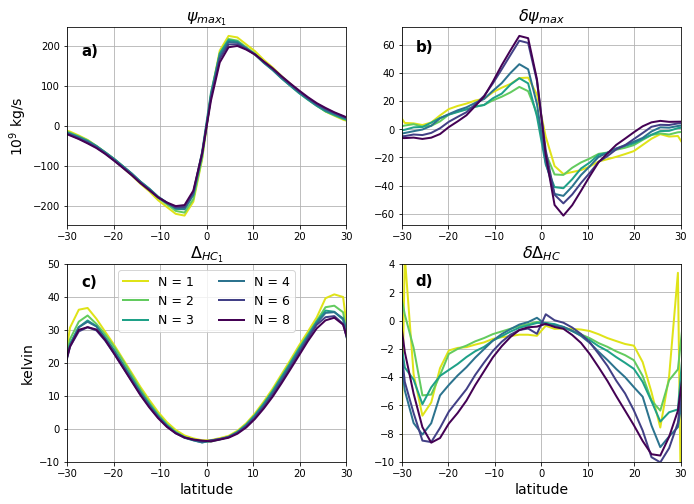

In [15]:
### Figure 3

fig=plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2,sharex = ax1)
ax3 = fig.add_subplot(2,2,3,sharex = ax1)
ax4 = fig.add_subplot(2,2,4,sharex = ax1)

for c,N in enumerate(Nlist):
    
    ### Plotting initial mass flux
    mass_init= mass_flux(runs.sel(N=N, amplitude=1))/1E9
    ax1.plot(lat, mass_init,color=colors[c],linewidth=2,label='N = '+str(N))
    
    ### Plotting mass flux anomaly
    mass_anom= (mass_flux(runs.sel(N=N, amplitude=2))-mass_flux(runs.sel(N=N, amplitude=1)))/1E9
    ax2.plot(lat, mass_anom,color=colors[c],linewidth=2,label='N = '+str(N))
    
    ### Plotting initial GMS
    gms_init = GMS(runs.sel(N=N, amplitude=1))
    ax3.plot(lat, gms_init,color=colors[c],linewidth=2,label='N = '+str(N))

    ### Plotting GMS anomaly
    gms_anom = GMS(runs.sel(N=N, amplitude=2))-GMS(runs.sel(N=N, amplitude=1))
    ax4.plot(lat, gms_anom,color=colors[c],linewidth=2,label='N = '+str(N))
    
    
### Setting ax1 attributes
ax1.set_xlim(-30,30)
ax1.set_xticks(range(-30,31,10))
ax1.grid()    
ax1.set_ylabel('$10^{9}$ kg/s', fontsize=14)
ax1.set_title('$\psi_{max_1}$', fontsize=16)
ax1.text(-27,175,'a)', fontsize=15, fontweight='bold')

### Setting ax2 attributes
ax2.grid()    
ax2.set_title('$\delta \psi_{max}$', fontsize=16)
ax2.text(-27,55,'b)', fontsize=15, fontweight='bold')

### Setting ax3 attributes
ax3.set_ylim(-10,50)
ax3.grid()
ax3.set_ylabel('kelvin', fontsize=14)
ax3.set_xlabel('latitude', fontsize=14)
ax3.set_title('$\Delta_{HC_1}$', fontsize=16)
ax3.legend(loc='upper center', ncol=2, fontsize=12.5)
ax3.text(-27,43,'c)', fontsize=15, fontweight='bold')


### Setting ax4 attributes
ax4.set_ylim(-10,4)
ax4.grid()
ax4.text(-27,2.5,'d)', fontsize=15, fontweight='bold')
ax4.set_xlabel('latitude', fontsize=14)
ax4.set_title('$\delta \Delta_{HC}$', fontsize=16)


$$ \delta F_{HC} (\phi) =  \psi_{max}(\phi) \delta \Delta_{HC}(\phi) +\delta \psi_{max}(\phi)\Delta_{HC}(\phi) +\text{residual}$$
    


Text(-28,0.79,'d)')

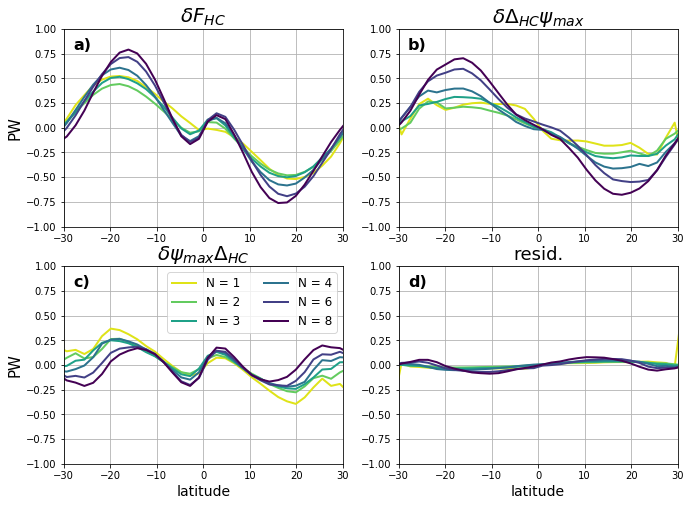

In [16]:
### Figure 4

fig=plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2,sharex = ax1,sharey = ax1)
ax3 = fig.add_subplot(2,2,3,sharex = ax1,sharey = ax1)
ax4 = fig.add_subplot(2,2,4,sharex = ax1,sharey = ax1)


for c,N in enumerate(Nlist):
    
    ### Calculating various terms
    HC_anom = anom1PW.HC_flux.sel(N=N)
    mass_i = mass_flux(runs.sel(N=N, amplitude = 1))
    mass_anom = mass_flux(runs.sel(N=N, amplitude = 2))- mass_i
    GMS_i = GMS(runs.sel(N=N, amplitude=1))*const.cpair
    GMS_anom = GMS(runs.sel(N=N, amplitude=2))*const.cpair - GMS_i
    
    
    ### plotting total HC energy flux
    ax1.plot(lat,HC_anom/1E15,color=colors[c],linewidth=2, label = 'N = '+str(N))     

    ### plotting thermodynamic term
    therm = (GMS_anom* mass_i)/1E15
    ax2.plot(lat,therm,color=colors[c],linewidth=2, label = 'N = '+str(N))
    
    ### plotting dynamic term
    dyn = (mass_anom*GMS_i)/1E15
    ax3.plot(lat,dyn,color=colors[c],linewidth=2, label = 'N = '+str(N))
    
    ### plotting residual term
    resid = HC_anom/1E15 - therm - dyn
    ax4.plot(lat,resid,color=colors[c],linewidth=2, label = 'N = '+str(N))

   
    
### Setting ax1 attributes    
ax1.set_xlim(-30,30)
ax1.set_ylim(-1,1)
ax1.grid()
ax1.set_ylabel('PW', fontsize=15)
ax1.text(-28,.79,'a)', fontsize=16, fontweight='bold')
ax1.set_title('$\delta F_{HC}$', fontsize=20)



### Setting ax2 attributes
ax2.grid()
ax2.set_title('$\delta \Delta_{HC}\psi_{max}$', fontsize=20)
ax2.text(-28,.79,'b)', fontsize=16, fontweight='bold')


### Setting ax3 attributes
ax3.grid()
ax3.set_xlabel('latitude', fontsize=14)
ax3.text(-28,.79,'c)', fontsize=16, fontweight='bold')
ax3.set_title('$\delta \psi_{max}\Delta_{HC}$', fontsize=20)
ax3.set_ylabel('PW', fontsize=15)
ax3.legend(ncol=2, loc='upper right', fontsize=12)

#### Setting ax4 attributes
ax4.grid()
ax4.set_xlabel('latitude', fontsize=14)
ax4.set_title('resid.', fontsize=18)
ax4.text(-28,.79,'d)', fontsize=16, fontweight='bold')





## Streamfunction Breakdown

$$\delta \psi_{sp}= \alpha \psi_{ref}$$

$$\alpha = \frac {\max{(\delta \psi)}}{\max{(\psi_{ref})}}$$

$$\delta \psi_{sh} =  \delta \psi - \delta \psi_{sp}$$

In [17]:
### Calculating a for psi split
weighted_a={}
for N in Nlist:
    weighted_a[N]=(max(mass_flux(runs.sel(N=N, amplitude=2)))-max(mass_flux(runs.sel(N=N, amplitude=1))))\
    /max(mass_flux(runs.sel(N=N, amplitude=1)))

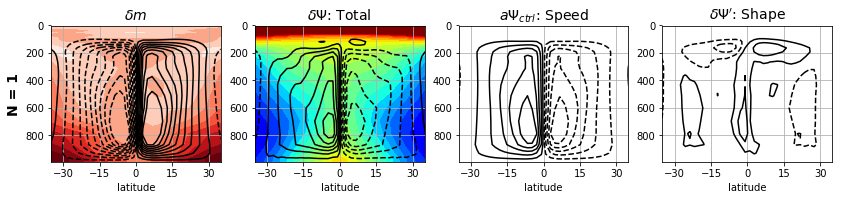

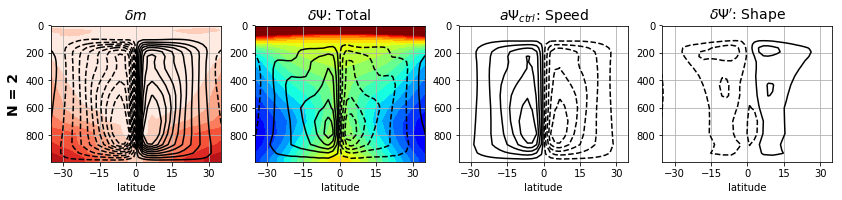

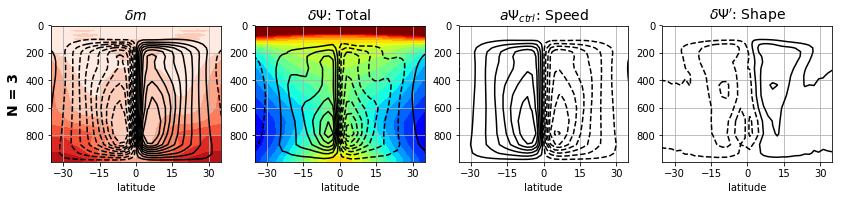

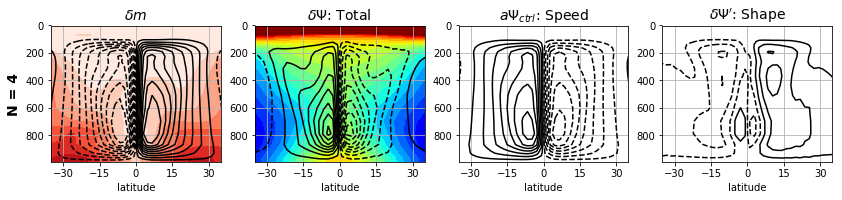

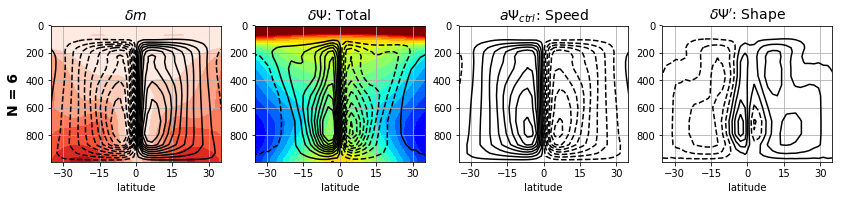

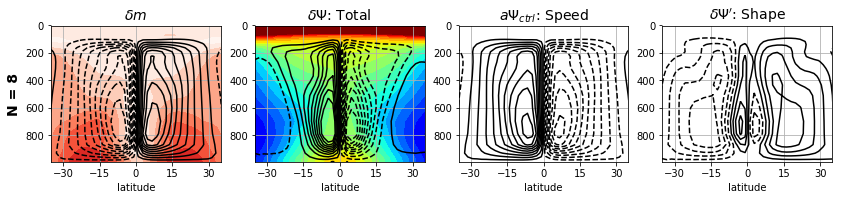

In [18]:
#### Figure 5 and A1



c = 1000
level = range(300,401,5)
ticks=range(300,410,10)

for N in Nlist:
    #### Calculating speed and shape component of streamfunction
    speed=runs.Psi.sel(N=N, amplitude = 1)*weighted_a[N]
    shape = anom1PW.Psi.sel(N=N) - speed
    
    fig = plt.figure(figsize=(14,2.5))
    
    
    ####Thermodynamic breakdown
    ax1 = fig.add_subplot(1,4,1)
    
    MSE_anom = anom1PW.MSE.sel(N=N)
    Psi_ctrl = runs.Psi.sel(N=N, amplitude = 1)
    ax1.contourf(lat,lev, MSE_anom/c, levels = np.linspace(0,8,9), cmap=plt.cm.Reds, extend='both' ) 
    ax1.contour(lat,lev, Psi_ctrl,levels = np.linspace(-180,180, 18), colors = 'k')
    
    
    ####Setting attributes for ax1
    ax1.grid()
    plt.gca().invert_yaxis()
    ax1.set_xticks(range(-30,31,15))
    ax1.set_xlim(-35,35)
    ax1.set_title('$\delta m$', fontsize=14)
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('N = '+str(N), fontsize=14, fontweight='bold')
    
    
    ####Dynamic Breakdown
    ax2 = fig.add_subplot(1,4,2)
    
    MSE_i = runs.MSE.sel(N=N, amplitude = 1)
    ax2.contourf(lat,lev,MSE_i/c,levels=level,cmap=plt.cm.jet, extend='both')
    ax2.contour(lat,lev,anom1PW.Psi.sel(N=N), colors='k', levels = np.linspace(-50,50,18))
    ax2.grid()

    ####Setting attributes for ax2
    ax2.set_title('$\delta \Psi$: Total', fontsize=14)
    ax2.set_xlabel('latitude')
    plt.gca().invert_yaxis()
    ax2.set_xlim(-35,35)
    ax2.set_xticks(range(-30,31,15))
    
    
    ####Speed component of streamfunction
    ax3 = fig.add_subplot(1,4,3)
    ax3.contour(lat,lev,speed, colors='k', levels = np.linspace(-50,50,18))
    
    
    ####Setting attributes for ax3
    ax3.grid()
    ax3.set_title('$a \Psi_{ctrl}$: Speed', fontsize=14)
    ax3.set_xlabel('latitude')
    plt.gca().invert_yaxis()
    ax3.set_xlim(-35,35)
    ax3.set_xticks(range(-30,31,15))
    
    
    ####Shape component of streamfunction
    ax4 = fig.add_subplot(1,4,4)
    ax4.contour(lat,lev,shape, colors='k', levels = np.linspace(-50,50,18))
    
    ####Setting attributes for ax4
    ax4.grid()
    ax4.set_title("$\delta \Psi'$: Shape", fontsize=14)
    ax4.set_xlabel('latitude')
    plt.gca().invert_yaxis()
    ax4.set_xlim(-35,35)
    ax4.set_xticks(range(-30,31,15))

## GMS Breakdown


$$\overline{v} = \frac{g} {2 \pi a \cos{\phi}} \frac {\partial \overline{\psi}}{\partial P}$$

$$\Delta_{HC_1} = 2 \pi a \cos{\phi} \int^{P_{sfc}}_{P_{top}}  [\overline{m_1}]\bigg[ \frac{g} {2 \pi a \cos{\phi}} \frac {\partial \overline{\psi}}{\partial P} \bigg]_{adj} \frac{dP}{g}  \psi_{max_1}^{-1}$$

$$    \delta \Delta_{M} = 2 \pi a \cos{\phi} \int^{P_{sfc}}_{P_{top}} [\overline{m}_2]\bigg[ \frac{g} {2 \pi a \cos{\phi}} \frac {\partial \overline{\psi_1}}{\partial P} \bigg]_{adj} \frac{dP}{g}  \psi_{max_1}^{-1} - \Delta_{HC_1}$$

$$\delta \Delta_{sh} = 2 \pi a \cos{\phi} \int^{P_{sfc}}_{P_{top}}  [\overline{m}_1]\bigg[ \frac{g} {2 \pi a \cos{\phi}} \frac {\partial( \overline{\psi_1 + \delta \psi_{sh}})}{\partial P} \bigg]_{adj} \frac{dP}{g}  \psi_{max_{sh}}^{-1} - \Delta_{HC_1}$$

$$\delta \Delta_{sp} = 2 \pi a \cos{\phi} \int^{P_{sfc}}_{P_{top}}  [\overline{m}_1]\bigg[ \frac{g} {2 \pi a \cos{\phi}} \frac {\partial( \overline{\psi_1 + \delta \psi_{sp}})}{\partial P} \bigg]_{adj} \frac{dP}{g}  \psi_{max_{sp}}^{-1} - \Delta_{HC_1}$$

$$\delta \Delta_{HC} \approx \delta \Delta_{M} +\delta \Delta_{sh} + \delta \Delta_{sp}$$



In [19]:
####Calculating mass flux directly from Psi
def mass_flux_psi(psi):
    t=np.zeros_like(lat)
    n=np.copy(t)
    mass_max=np.copy(t)
    for m in range(len(t)):
        t[m]=np.amax(psi[:,m])
        n[m]=np.amin(psi[:,m])

        if abs(t[m])>=abs(n[m]):
            mass_max[m]=t[m]
        else:
            mass_max[m]=n[m]

    mass_max=np.asarray(mass_max)*10**9
    return mass_max


####Calculating mass flux for streamfunction at 2 PW assuming only changes in HC speed and shape
speed_mass_flux_2PW={}
shape_mass_flux_2PW={}

for N in Nlist:
    a=weighted_a[N]
    psi_init = runs.Psi.sel(N=N, amplitude = 1)
    speed_2PW=psi_init * (1.+a)
    speed_mass_flux_2PW[N]=mass_flux_psi(speed_2PW)
    shape_anom = anom1PW.Psi.sel(N=N) - psi_init*a 
    shape_2PW = psi_init+shape_anom
    shape_mass_flux_2PW[N]=mass_flux_psi(shape_2PW)

In [20]:
### Calculating mean meridional winds from streamfunction
def Psi2V(psi):
    factor = 2*np.pi*const.rearth/const.gravit*1E-9
    test = np.gradient(psi,axis = 0,edge_order=0)
    return test/(ctrl.dP*np.cos(deg2rad(lat))*factor)

### Adjusting meridional winds for mass imbalance
def V_adj_from_V(V):
    N=np.zeros_like(V)
    S=np.zeros_like(N)
    
    for y in range(26):
            for x in range(96):
                if V[y,x] > 0:
                    N[y,x]= V[y,x]
                elif V[y,x] < 0: 
                    S[y,x]= V[y,x]
    S=np.array(S)
    N=np.array(N)
    n= column_integral(N)  
    s=column_integral(S)   
    V_ad=N-(S*np.array(n/s))
    Vad_array = xr.DataArray(V_ad, coords = ctrl.V.coords, dims = ctrl.V.dims)
    return Vad_array

### Calculating HC energy from from MSE field and adjusted meridional winds
def HC_flux(MSE, V_adj):
    constants=2*np.pi*const.rearth*np.cos(np.deg2rad(ctrl.lat))
    HC_flux=constants*column_integral(MSE*V_adj)
    return xr.DataArray(HC_flux, coords = ctrl.HT_atm.coords, dims = ctrl.HT_atm.dims)

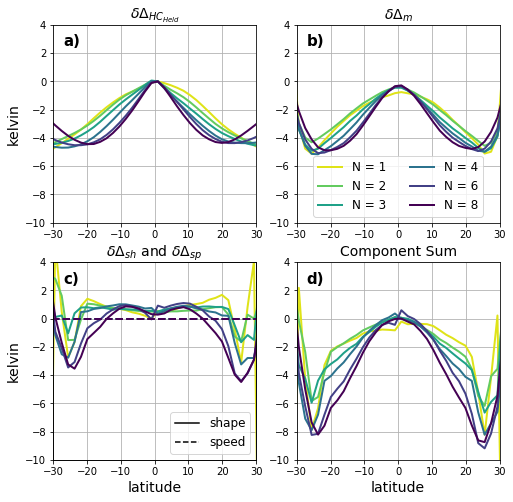

In [21]:
####Figure 7



ht=np.zeros_like(lat)

fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2,sharex = ax1,sharey = ax1)
ax3 = fig.add_subplot(2,2,3,sharex = ax1,sharey = ax1)
ax4 = fig.add_subplot(2,2,4,sharex = ax1,sharey = ax1)



for c,N in enumerate(Nlist):

    
    ####Calculating GMS assuming Held (2001)
    m2 = runs.MSE.sel(N=N, amplitude = 2)[25,:]
    m1 = runs.MSE.sel(N=N, amplitude = 1)[25,:]
        
    for x in range(len(lat)):
        ht[x]=(m2[48]-m2[x])-(m1[48]-m1[x])
    ax1.plot(lat,ht/const.cpair,color=colors[c],linewidth=2,label=str(N))
  


    ####Calculating various terms necesarry GMS breakdown
    psi_init = runs.Psi.sel(N=N, amplitude = 1)
    MSE_init = runs.MSE.sel(N=N, amplitude = 1)
    MSE_2  = runs.MSE.sel(N=N, amplitude = 2)
    psi_anom = anom1PW.Psi.sel(N=N)
    speed_anom=psi_init*weighted_a[N]
    shape_anom = psi_anom - speed_anom
    psi_shape = psi_init +shape_anom
    psi_speed = psi_init + speed_anom
    mass_speed = mass_flux_psi(psi_speed)
    mass_shape = mass_flux_psi(psi_shape)
    mass_init = mass_flux_psi(psi_init)
    
    
    

    ####Calculating change in GMS associated with MSE
    GMS_2 = HC_flux(MSE_2, V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_1 = HC_flux(MSE_init, V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_mse = (GMS_2 - GMS_1)/const.cpair
    ax2.plot(lat,GMS_mse,color=colors[c],linewidth=2,label='N = '+str(N))
    
    
    
    
    ####Calculating change in speed component of GMS
    GMS_sp2 = HC_flux(MSE_init, V_adj_from_V(Psi2V(psi_speed)))/(mass_speed)
    GMS_sp1 = HC_flux(MSE_init,  V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_speed = (GMS_sp2-GMS_sp1)/const.cpair
    ax3.plot(lat,GMS_speed,color=colors[c],linestyle='--',linewidth=2,label='N = '+str(N))
    
    
    
    
    ####Calculating change in shape component of GMS
    GMS_sh2 = HC_flux(MSE_init, V_adj_from_V(Psi2V(psi_shape)))/(mass_shape)
    GMS_sh1 = HC_flux(MSE_init,  V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_shape = (GMS_sh2-GMS_sh1)/const.cpair
    ax3.plot(lat,GMS_shape,color=colors[c],linewidth=2,label='N = '+str(N))
    
    
    
    
    GMS_combo = GMS_mse  + GMS_shape
    ax4.plot(lat,GMS_combo,color=colors[c],linewidth=2,label='N = '+str(N))

    
    
####Setting attributes for ax1    
ax1.set_xlim(-30,30)
ax1.set_ylim(-10,4)
ax1.grid()
ax1.text(-27,2.5,'a)', fontsize=15, fontweight='bold')
ax1.set_ylabel('kelvin', fontsize=14)
ax1.set_title('$\delta \Delta_{HC_{Held}}$', fontsize=14)

####Setting attributes for ax2
ax2.grid()
ax2.legend(loc='lower center',ncol=2, fontsize = 12)
ax2.text(-27,2.5,'b)', fontsize=15, fontweight='bold')
ax2.set_title('$\delta \Delta_{m}}$', fontsize=14)

####Setting attributes for ax3
ax3.grid()
ax3.text(-27,2.5,'c)', fontsize=15, fontweight='bold')
ax3.set_ylabel('kelvin', fontsize=14)
ax3.set_xlabel('latitude', fontsize=14)
ax3.set_title('$\delta \Delta_{sh}}$ and $\delta \Delta_{sp}}$', fontsize=14)


####Setting attributes for ax4
ax4.grid()
ax4.text(-27,2.5,'d)', fontsize=15, fontweight='bold')
ax4.set_xlabel('latitude', fontsize=14)
ax4.set_title('Component Sum', fontsize=14)


####Adding speed/shape legend for ax3
ax5 = ax3.twinx()
ax5.plot([],'k',label='shape') 
ax5.plot([],'k--',label='speed')
ax5.legend(loc = 'lower right',fontsize=12)
plt.tick_params(
    axis='y',          
    which='both',      
    right='off',      
    labelright='off')



## Full HC equation linear expansion

$$\delta F_{HC}(\phi) =  \delta \Delta_{sh}(\phi)\psi_{max_1}(\phi) + \delta \Delta_{sp}(\phi)\psi_{max_1}(\phi) + \delta \Delta_{m}(\phi)\psi_{max_1}(\phi) + \delta\psi_{max_{sp}}\Delta_{HC_1} + \delta\psi_{max_{sh}}\Delta_{HC_1} + \text{residual}$$

Text(-28,0.79,'f)')

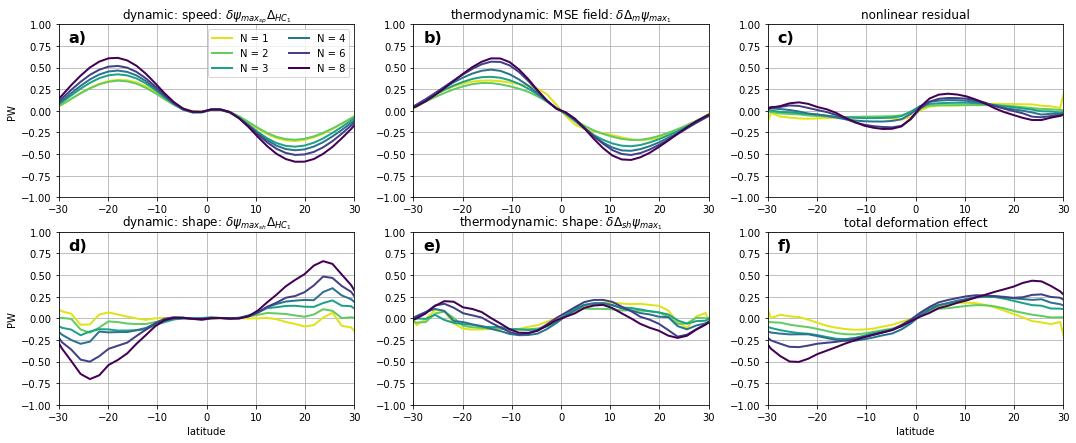

In [22]:
#### Figure 6


fig = plt.figure(figsize=(18,7))

ax1=fig.add_subplot(2,3,1)
ax2=fig.add_subplot(2,3,2,sharex = ax1,sharey = ax1)
ax3=fig.add_subplot(2,3,3,sharex = ax1,sharey = ax1)
ax4=fig.add_subplot(2,3,4,sharex = ax1,sharey = ax1)
ax5=fig.add_subplot(2,3,5,sharex = ax1,sharey = ax1)
ax6=fig.add_subplot(2,3,6,sharex = ax1,sharey = ax1)
for c,N in enumerate(Nlist):
    
    ####Calculating various necessary terms for breakdown
    psi_init = runs.Psi.sel(N=N, amplitude = 1)
    psi_2 = runs.Psi.sel(N=N, amplitude = 2)
    speed_anom=psi_init*weighted_a[N]
    psi_anom = anom1PW.Psi.sel(N=N)
    shape_anom = psi_anom - speed_anom
    psi_shape = psi_init +shape_anom
    psi_speed = speed_anom+psi_init
    mass_shape = mass_flux_psi(psi_shape)
    mass_speed = mass_flux_psi(psi_speed)
    MSE_init = runs.MSE.sel(N=N, amplitude = 1)
    MSE_2 = runs.MSE.sel(N=N, amplitude = 2)
    mass_init = mass_flux_psi(psi_init)
    
    
   ####Calculating full energy flux breakdown 
    
    ####GMS_MSE
    GMS_2 = HC_flux(MSE_2, V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_1 = HC_flux(MSE_init, V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_mse = (GMS_2 - GMS_1)
    
    MSE_comp = (GMS_mse * mass_init)/1E15
    
    ### GMS_SH
    
    GMS_sh2 = HC_flux(MSE_init, V_adj_from_V(Psi2V(psi_shape)))/(mass_shape)
    GMS_sh1 = HC_flux(MSE_init,  V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_shape = (GMS_sh2-GMS_sh1)
    
    sh_comp = (GMS_shape * mass_init)/1E15
    
    
    ### GMS_sp
    
    GMS_sp2 = HC_flux(MSE_init, V_adj_from_V(Psi2V(psi_speed)))/(mass_speed)
    GMS_sp1 = HC_flux(MSE_init,  V_adj_from_V(Psi2V(psi_init)))/(mass_init)
    GMS_speed = (GMS_sp2-GMS_sp1)
    
    sp_comp = (GMS_speed*mass_init)/1E15
    
    ####Mass_speed
    sp_anom =( (mass_speed - mass_init) * GMS_1)/1E15
    
    ####Mass_shape 
    sh_anom = ( (mass_shape - mass_init) * GMS_1)/1E15
    
    ####Component sum
    total = MSE_comp+ sh_comp + sp_comp + sp_anom + sh_anom
    

    ####Total energy flux anomaly
    HC_anom = anom1PW.HC_flux.sel(N=N)/1E15
    
    deformation_effect = sh_comp + sh_anom
    ####nonlinear response
    nonlinear = HC_anom - total
    
    
    ####plotting breakdown
    ax1.plot(lat, sp_anom, color=colors[c], linewidth = 2, label = 'N = '+str(N))
    
    ax2.plot(lat, MSE_comp, color=colors[c], linewidth = 2)
    
    ax3.plot(lat, nonlinear, color=colors[c], linewidth = 2)
    
    ax4.plot(lat, sh_anom, color=colors[c], linewidth=2)
    
    ax5.plot(lat, sh_comp, color=colors[c], linewidth = 2)
    
    ax6.plot(lat, deformation_effect , color=colors[c], linewidth = 2)
    
    
    
    
    
    
    
    
    
    

####Setting attributes for ax1    
ax1.set_xlim(-30,30)
ax1.set_ylim(-1,1)
ax1.grid() 
ax1.set_title('dynamic: speed: $\delta\psi_{max_{sp}}\Delta_{HC_1}$')
ax1.set_ylabel('PW') 
ax1.legend(loc='upper right',ncol=2)    
ax1.text(-28,.79,'a)', fontsize=16, fontweight='bold') 
    
    

####Setting attributes for ax2
ax2.grid() 
ax2.set_title('thermodynamic: MSE field: $\delta \Delta_{m}\psi_{max_1}$')
ax2.text(-28,.79,'b)', fontsize=16, fontweight='bold')



####Setting attibutes for ax3
ax3.grid() 
ax3.set_title('nonlinear residual')
ax3.text(-28,.79,'c)', fontsize=16, fontweight='bold')

####Setting attributes for ax4
ax4.grid() 
ax4.set_title('dynamic: shape: $\delta\psi_{max_{sh}}\Delta_{HC_1}$')
ax4.set_ylabel('PW') 
ax4.set_xlabel('latitude')
ax4.text(-28,.79,'d)', fontsize=16, fontweight='bold')
####Setting attributes for ax5
ax5.grid() 
ax5.set_title('thermodynamic: shape: $\delta \Delta_{sh}\psi_{max_1}$')
ax5.text(-28,.79,'e)', fontsize=16, fontweight='bold')
####Setting attributes for ax6
ax6.grid() 
ax6.set_title('total deformation effect')
ax6.set_xlabel('latitude')
ax6.text(-28,.79,'f)', fontsize=16, fontweight='bold')




# HC Dynamical Analysis

- Eddy momentum flux divergence:
\begin{equation}
f(1-R_0)\overline{v}\approx S_e
\end{equation}



\begin{equation}
R_0=\frac{-\overline{\zeta}}{f}
\end{equation}

- for $R_0$ -> 1, angular momentum is conserved
- for $R_0$ -> 0, HC is controlled by eddy momentum



\begin{equation}
\psi(\phi,p)=\frac{2\pi a \cos \phi}{g}\int ^p _0 \overline{v}dp'
\end{equation}

- Can Break up $\Psi$ into eddy and thermal components

\begin{equation}
\Psi=\Psi_e+\Psi_m
\end{equation}

with

\begin{equation}
\Psi_e(\phi,P)=\frac{2\pi a \cos \phi}{fg} \int ^P _0 S_e dP'
\end{equation}


and

\begin{equation}
\Psi_m=\Psi-\Psi_e
\end{equation}



In [23]:

### Eddy momentum flux divergence
def S_e(N,A):
    datapath1 = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"        
    datapath2=  "/clim/"
    model = 'QAqu_'+'N'+str(N)+'_'+str(A)+'PW'
    ncfile= nc.Dataset(datapath1+model+datapath2+model+'.cam.h0.rel_vort.nc','r')
    r0=ncfile.variables['R_0'][:]
    f=ncfile.variables['coriolis'][:]
    v=runs.V.sel(N=N, amplitude=A)
    se=f*(1-r0)*v
    ncfile.close()
    return se



### Streamfunction function used in pyCESM
def overturning_improved(V, lat_deg):
    a=const.rearth
    dP=ctrl.dP
    datapath1 = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"        
    datapath2=  "/clim/"
    model = 'QAqu_ctrl'
    ncfile= nc.Dataset(datapath1+model+datapath2+model+'.cam.h0.rel_vort.nc','r')
    f=ncfile.variables['coriolis'][:]
    field = (V * dP * np.cos(np.deg2rad(lat)))
    factor = 2*np.pi*a/(9.81*f)*1E-9
    psi = np.cumsum( np.array(field), axis=0)*factor
    ncfile.close()
    return psi

### Eddy-Driven Streamfunction
def Psi_e(N,A):
    model='N'+str(N)+'_'+str(A)+'PW'
    psi_e=overturning_improved(S_e(N,A),lat)
    return psi_e

### Momentum-Conserving Streamfunction
def Psi_m(N,A):
    
    psi=runs.Psi.sel(N=N, amplitude=A)
    psi_m=psi-Psi_e(N,A)
    return psi_m


### Mass flux of Eddy-Driven Component above boundary layer
def eddy_mass_flux(N,A):
    t=[None]*len(lat)
    n=[None]*len(lat)
    mass_max=[None]*len(lat)
    for m in range(len(lat)):
        t[m]=np.amax(Psi_e(N,A)[:21,m])
        n[m]=np.amin(Psi_e(N,A)[:21,m])
        if abs(t[m])>=abs(n[m]):
            mass_max[m]=t[m]
        else:
            mass_max[m]=n[m]
    mass_max=np.asarray(mass_max)*10**9
    return mass_max


### Mass flux of thermally-direct momentum-conserving component above boundary layer
def thermal_mass_flux(N,A):
    t=[None]*len(lat)
    n=[None]*len(lat)
    mass_max=[None]*len(lat)
    for m in range(len(lat)):
        t[m]=np.amax(Psi_m(N,A)[:21,m])
        n[m]=np.amin(Psi_m(N,A)[:21,m])
        if abs(t[m])>=abs(n[m]):
            mass_max[m]=t[m]
        else:
            mass_max[m]=n[m]
    mass_max=np.asarray(mass_max)*10**9
    return mass_max



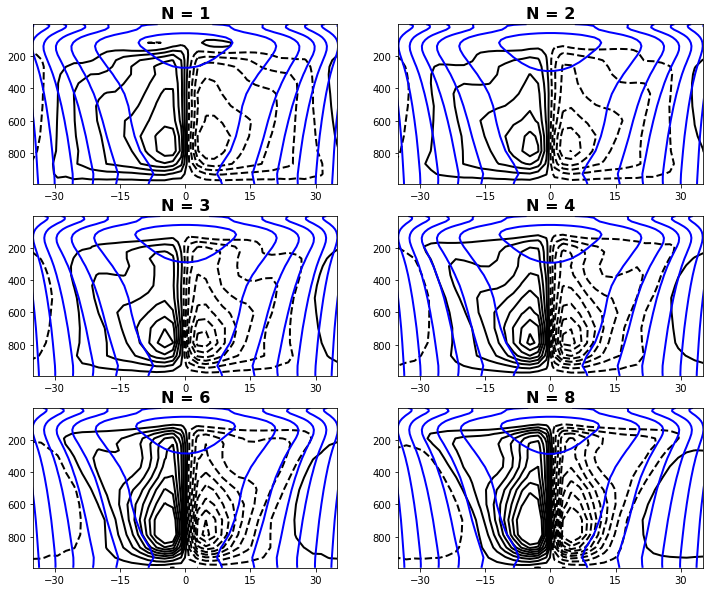

In [24]:
#### Figs 8 and A2

fig = plt.figure(figsize=(12,10))
for s,N in enumerate(Nlist):
    ax=fig.add_subplot(3,2,s+1)
    ### Calculating absolute momentum
    omega= const.omega
    a=const.rearth
    plan_momentum= omega * (np.cos(np.deg2rad(lat))*a)**2
    rel_momentum= runs.U.sel(N=N, amplitude=1)*np.cos(np.deg2rad(lat))*a
    momentum = np.swapaxes(plan_momentum+rel_momentum,0,1)
    ### Plotting momentum and streamfunction anomaly
    ax.contour(lat,lev,anom1PW.Psi.sel(N=N), colors = 'k', levels = np.linspace(-50,50,18), linewidths = 2)
    levels=np.linspace(0,3E9,20)
    ax.contour(lat,lev,momentum, colors = 'b', levels=levels, linewidths=2)
    ### Setting panel attributes
    plt.gca().invert_yaxis()
    ax.set_xlim(-35,35)
    ax.set_xticks(range(-30,31,15))
    ax.set_title('N = '+str(N), fontweight='bold', fontsize=16)

        


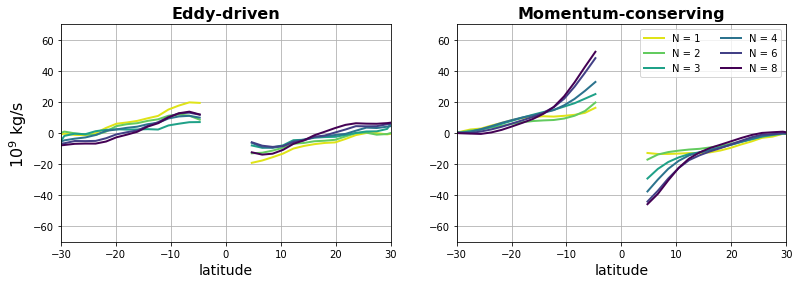

In [25]:
### Fig. 8

fig = plt.figure(figsize=(13,4))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2,sharex = ax1,sharey = ax1)
for c,N in enumerate(Nlist):
    
    ### plotting change in eddy-driven mass flux
    M_e=eddy_mass_flux(N,2)-eddy_mass_flux(N,1)
    ax1.plot(lat[:46],M_e[:46]/1E9,color=colors[c],linewidth=2,label='N = '+str(N))
    ax1.plot(lat[50:],M_e[50:]/1E9,color=colors[c],linewidth=2)
    
    
    ### plotting change in momentum-conserving mass flux
    M_t=thermal_mass_flux(N,2) - thermal_mass_flux(N,1)    
    ax2.plot(lat[:46],M_t[:46]/1E9,color=colors[c],linewidth=2,label='N = '+str(N))
    ax2.plot(lat[50:],M_t[50:]/1E9,color=colors[c],linewidth=2)
    
    
    
### Setting Panel Attributes
ax1.set_xlim(-30,30)
ax1.set_ylim(-70,70)
ax1.grid()
ax1.set_xlabel('latitude', fontsize=14)    
ax1.set_ylabel('$10^{9}$ kg/s', fontsize=16)
ax1.set_title('Eddy-driven', fontsize=16, fontweight='bold')

ax2.grid()
ax2.set_xlabel('latitude', fontsize=14) 
ax2.set_title('Momentum-conserving', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right', ncol=2)